# Fundus Image EDA - Color Channels

**TODO**:
- Is LAB giving more color infor that we can do spectral analysis on or is best jut for pulling out intensity without affecting luminance
- TODO: Adding back yellow Vs seperate yellow for pigment analysis
- HSV ne? 

In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline 

##hack don't know why i suddenly need to do this :/
plt.rcParams['axes.facecolor'] = 'white'

In [2]:
import mflow
from zdata import PdDataStats, ZPdDataset
import utilz, content, preprocess, extract
import report


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer , OneHotEncoder 
from sklearn.linear_model import LogisticRegression
from sklearn import svm 


In [3]:
import pickle
import glob

In [4]:
report.ZReporter.start("fundusEDA_Colorz")

In [5]:
pdstats = PdDataStats(
                {PdDataStats.DATA_DICT_RECORDZ_KEY: content.STARE_FUNDUS_CONTENT_FPATH,
                PdDataStats.DATA_DICT_HAS_HEADERZ_KEY: True,
                'rec_parser': utilz.FileIO.row_parser                     
                },
                 ftype=PdDataStats.TYPE_TXT_LINES_FILE ) 

pdstats.dframe.describe() 

,fname,fpath,ishape,imin,imax,imean,istd,Normal,Emboli,BRAO,...,ASR,HTR,Coats,MA,CNV,UNDEF,dcodez_id,dcodez_short,dcodez_desc,dnotes
count,397,397,397,397,397,397,397,397,397,397,...,397,397,397,397,397,397,397,397,397,210
unique,397,397,1,2,17,397,397,2,2,2,...,2,2,2,2,2,2,48,48,48,75
top,im0042,/mnt/externz/zRepoz/datasets/fundus/stare/im00...,"(605, 700, 3)",0,255,81.50181739472649,90.01779933409217,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,14,UNDEF,Unknown Diagnosis,Choroidal Neovascularization AND Age Related M...
freq,1,1,397,371,373,1,1,358,384,390,...,364,361,383,389,336,239,90,90,90,33


In [61]:
### **** TODO: fix sick+okay/undef 88888
_CLASSES = ['sick', 'okay', 'undef', 'sick-n-undef']
_N_CLASSES = 22
    
def get_data_infor(X_data):    
    if _N_CLASSES <= 2:
        cname = 'Normal'
    else:
        cname = 'condition'
    data_infor = [ f"{x[0]}__{_CLASSES[int(float(x[1]))]}__{x[2]}" for x in zip(X_data['fname'],X_data[cname], X_data['dcodez_short'])]
    print(data_infor[0])
    return data_infor


if _N_CLASSES > 2:
    pdstats.dframe['condition'] = np.where( (tmp['Normal'] == '1.0') & (tmp['UNDEF'] == '0.0') , 1, 
                                np.where( (tmp['Normal'] == '0.0')&(tmp['UNDEF'] == '1.0'), 2, 
                                    np.where((tmp['Normal'] == '1.0')&(tmp['UNDEF'] == '1.0'), 3, 0)) ) 
    print( pdstats.dframe['condition'].unique() )
    print( pdstats.dframe['condition'].value_counts())
    _YDATA = pdstats.dframe['condition'].values.astype(np.float32) ##TODO: 'dcodez_short'
    _N_CLASSES = len( _CLASSES)
else:
    _Y_DATA = pdstats.dframe['Normal'].values.astype(np.float32) ##TODO: 'dcodez_short'
    _N_CLASSES = 2

print(_Y_DATA[107:107+7])


_DATA_INFOR = get_data_infor(pdstats.dframe) 
# _DATA_INFOR 

[0 2 1 3]
0    202
2    156
1     37
3      2
Name: condition, dtype: int64
[0. 0. 0. 0. 0. 0. 0.]
im0001__sick__BDR-NPDR


In [36]:
tz = ['lbp', 'vessel', 'green', 'red', 'blue', 'yellow', 'eigenz', 'color-eq',  'update-grb'] #, 'update-erb'
chanz = [ *list(range(6)), 9, (6,7,8)]

def fda_run(pipez, fdir, trainin_X=pdstats.dframe, save_fmap_dir=None):
    tmpz = Pipeline( pipez ).fit_transform(trainin_X)
    for fp, norm, flbl, img_chanz in zip(trainin_X['fname'],trainin_X['Normal'], trainin_X['dcodez_short'], tmpz):
        c = img_chanz.shape[2]        
        imgz = [ *[ img_chanz[:,:,i] for i in chanz ], img_chanz[:,:,2:5] ] #, img_chanz[:,:,(3,4,9)]
        
        fn = _CLASSES[int(float(norm))]
        save_to = f"{fp}_{fn}__{flbl}" 
        print( save_to )
        utilz.Image.plot_images_list( imgz, titlez=tz, nc=len(imgz) , cmap='gray', 
                                     save= save_to, savedpi=1200,
                                        tdir=fdir)
        if save_fmap_dir is not None:
            with open(f"{save_fmap_dir}/{save_to}.fmap.pkl", "wb") as fd:
                pickle.dump( img_chanz, fd)
                
                
def fda_load_fmapz(fmapz_dir):
    for fmap_file in glob.glob(f"{fmapz_dir}/*.fmap.pkl"):
        print("file: ", fmap_file)
        with open( fmap_file, "rb") as fd:
            fmap = pickle.load( fd )
        imgz = [ *[ fmap[:,:,i] for i in chanz ], fmap[:,:,2:5]]
        utilz.Image.plot_images_list( imgz, titlez=tz, nc=len(imgz) , cmap='gray')
        yield fmap

In [37]:
# _FMAPZ_DIR = "/mnt/fatsie/xRepoz/output/__00_FMAPZ/F47"
_OUTPUT_DIR = "./output"
_FMAPZ_DIR = f"{_OUTPUT_DIR}/__00_FMAPZ/F47"
_IMZ = ['im0014', 'im0015', 'im0032', 'im0044', 'im072', 'im0203', 'im0120', 'im0119', 'im0264', 'im0013']


In [38]:
def run_fda_proc(red_thresh=0.95, col_space='rgb', crop_r=0.75, lbp_r=3, n_comps=3, 
                 fmap_dir=_FMAPZ_DIR, specifc_imgz=_IMZ, out_dir="./output/fda_47_fin"):
    ## ==== 1. Def Data PIPELINEZ 
    loader_p75 = [ ('fetch_img75', preprocess.LoadImageFileTransform('fpath', crop_ratio=crop_r) ), ]
    ## 1. First the color channelz 
    funduzor_1 = [ ('funduzor', extract.FundusColorChannelz(red_thresh=red_thresh, color_space=col_space) ),]
    ## 2. At start for vessel infor <--- edgez, 
    lbp_adder = [ ('lbp_add', extract.FundusAddLBP(g_channel=1, lbp_radius=lbp_r ) ),]
    ## 3. At append 
    eigenz_append =[('eigenz_append', extract.EigenzChannelz(g_channel=1, topn=n_comps, append_component=True)),]

    #### ==== 2. Pipe it 
    ## redump collection of mappings 
    fda_opts = [(loader_p75+funduzor_1+lbp_adder+eigenz_append,  out_dir), ] 
    # dtmp = pdstats.dframe.sample(3) 
    dtmp = pdstats.dframe if specifc_imgz is None else pdstats.dframe[ pdstats.dframe['fname'].isin( specifc_imgz ) ]

    for pipez, fdir in fda_opts:
        fda_run(pipez, fdir, trainin_X=dtmp , save_fmap_dir=fmap_dir) #


im0013_sick__BDR-NPDR


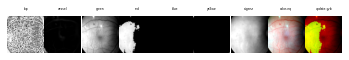

im0014_sick__UNDEF


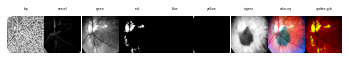

im0015_sick__UNDEF


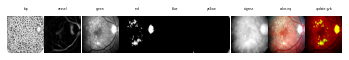

im0032_okay__Normal


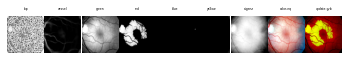

im0044_sick__UNDEF


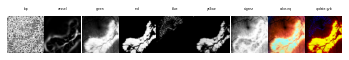

im0119_okay__Normal


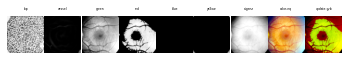

im0120_okay__Normal


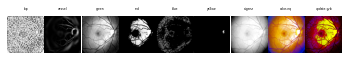

im0203_sick__PDR


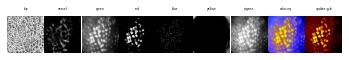

im0264_sick__UNDEF++HTR


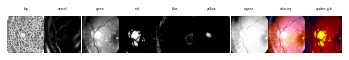

In [39]:
# run_fda_proc( red_thresh=0.83 , specifc_imgz = None)
run_fda_proc( red_thresh=0.83 )

## LBA SPACE

In [15]:
#run_fda_proc(col_space='lab', out_dir="./output/fda_47_fin_LAB", red_thresh=0.85)

# Check Pickle Results

file:  ./output/__00_FMAPZ/F47/im0013_sick__BDR-NPDR.fmap.pkl


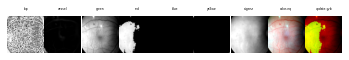

file:  ./output/__00_FMAPZ/F47/im0014_sick__UNDEF.fmap.pkl


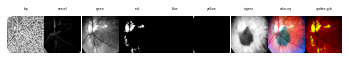

file:  ./output/__00_FMAPZ/F47/im0015_sick__UNDEF.fmap.pkl


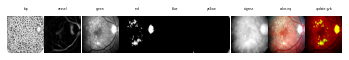

file:  ./output/__00_FMAPZ/F47/im0032_okay__Normal.fmap.pkl


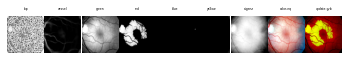

file:  ./output/__00_FMAPZ/F47/im0044_sick__UNDEF.fmap.pkl


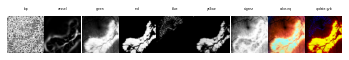

file:  ./output/__00_FMAPZ/F47/im0119_okay__Normal.fmap.pkl


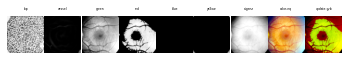

In [41]:
# _FMAPZ_DIR = "/mnt/fatsie/xRepoz/output/__00_FMAPZ__RGB_LAB_combo/F47" ## with Yellow + LAB&RGB

b = 0
for _ in ( fda_load_fmapz(_FMAPZ_DIR) ):
#     print('doing someting ', b)
    b += 1
    if b == 6:
        break